# Untitled Notebook

What's this notebook about?

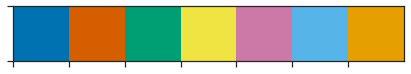

In [82]:
import sys
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [83]:
fpa_ip = pd.read_csv(
    '../pipeline/FPA/proteus_output/FPA_vs_col0.tsv',
    sep='\t'
)
fpa_ip['gene_id'] = fpa_ip.protein.str.split('.', expand=True)[0]
fpa_ip = fpa_ip.sort_values('median_logFC', ascending=False)
fpa_ip.head()

,protein,pval,fdr,lower_ci_logFC,median_logFC,upper_ci_logFC,lower_ci_av_exprs,median_av_exprs,upper_ci_av_exprs,col0,FPA,gene_id
265,AT2G43410.2,0.000223,0.082883,9.602227,10.980012,11.836611,21.538075,21.966374,22.655267,1,3,AT2G43410
325,AT3G12130.1,0.000174,0.082883,6.263804,7.308159,9.938657,15.934393,17.249641,17.771819,0,3,AT3G12130
343,AT3G15010.1,0.002273,0.100440,5.162846,6.342568,8.120211,17.430693,18.319515,18.909376,1,3,AT3G15010
640,AT5G40490.1,0.004347,0.100440,5.283210,6.308190,7.576906,17.471655,18.106013,18.618503,1,3,AT5G40490
235,AT2G33410.1,0.002163,0.100440,3.947398,6.152830,7.843524,15.832266,16.677613,17.780329,0,3,AT2G33410


In [84]:
cpa_factors = {
    'AT2G43410': 'FPA',
    'AT5G51660': 'CPSF160',
    'AT5G23880': 'CPSF100',
    'AT1G61010': 'CPSF73-I',
    'AT5G13480': 'FY',
    'AT1G71800': 'CSTF64',
    'AT1G17760': 'CSTF77',
    'AT1G27595': 'TANG1',
    'AT5G01400': 'ESP4',
    'AT4G25550': 'CFIS2',
    'AT5G55670': 'CPSF6',
    'AT1G13190': 'CPSF7',
    'AT3G04680': 'CLP1',
    'AT2G36480': 'PCFS2',
    'AT4G04885': 'PCFS4',
}
splicing_factors = {
    'AT1G14650': 'SF3A1',
    'AT5G64270': 'SF3B1',
    'AT3G55220': 'SF3B3',
    'AT2G18510': 'SF3B4',
    'AT2G30000': 'PHF5A',
    'AT4G36690': 'U2AF65A',
    'AT5G42820': 'U2A35B',
}

ctd_factors = {
    'AT4G35800': 'NRPB1',
    'AT4G21710': 'NRPB2',
    'AT5G64960': 'CDKC2',
    'AT4G21670': 'CPL1',
    'AT1G75660': 'XRN3',
}

ap_factors = {
    'AT2G43410': 'FPA',
    'AT4G16280': 'FCA',
    'AT5G40490': 'HLP1',
    'AT1G76940': 'NSRA',
    'AT3G12130': 'KHZ1',
    'AT5G06770': 'KHZ2',
    'AT2G21660': 'GRP7',
    'AT4G39260': 'GRP8',
    'AT2G19520': 'FVE',
    'AT5G58470': 'TAF15b',
    'AT3G04610': 'FLK',
    'AT4G26000': 'PEP',
    'AT3G12680': 'HUA1',
    'AT5G64390': 'HEN4',
    'AT4G12640': 'AtSPEN2',
}

m6a_factors = {
    'AT2G43410': 'FPA',
    'AT3G05680': 'VIR',
    'AT4G10760': 'MTA',
    'AT3G54170': 'FIP37',
    'AT4G09980': 'MTB',
}

In [85]:
def get_colors(res, label_genes):
    c = []
    for gene_id in res.gene_id:
        for i, g in enumerate(label_genes):
            if gene_id in g:
                c.append(i)
                break
        else:
            c.append(len(label_genes))
    return np.array(c)


def volcano_plot(res, label_genes, ax=None):
    bins = np.linspace(res.median_av_exprs.min(), res.median_av_exprs.max(), 11)
    size = np.digitize(res.median_av_exprs, bins) * 20
    c = get_colors(res, label_genes)
    order = np.argsort(c)[::-1]
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(
        x=res.median_logFC.values[order],
        y=-np.log10(res.pval).values[order],
        c=c[order],
        s=size[order],
        cmap=ListedColormap(list(pal.as_hex())[:len(label_genes)] + ['#dddddd']),
        edgecolor='white',
    )
    for _, p_val, fdr, _,  logFC, *_, gene_id in res.itertuples(index=False):
        for g in label_genes:
            if gene_id in g:
                ax.annotate(
                    s=g[gene_id],
                    xy=(logFC, -np.log10(p_val)),
                    xytext=(logFC, -np.log10(p_val)),
                    ha='left',
                    fontsize=10
                )
                break
    ax.set_xlabel('Median Log2 Fold Change')
    ax.set_ylabel('-Log10 P Value')
    return ax

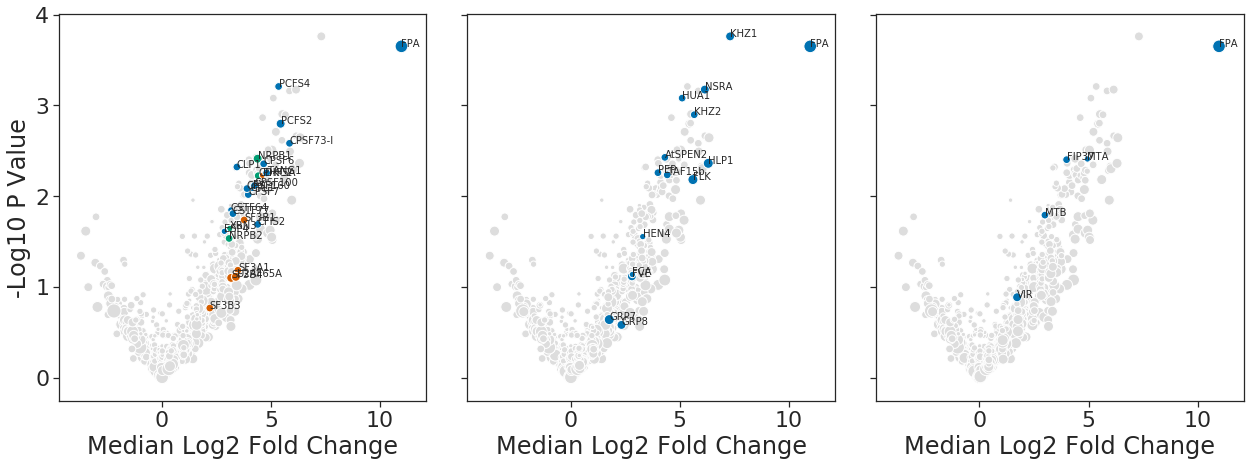

In [86]:
fig, axes = plt.subplots(figsize=(18, 7), ncols=3, sharex=True, sharey=True)
   
volcano_plot(fpa_ip, [cpa_factors, splicing_factors, ctd_factors], axes[0])
volcano_plot(fpa_ip, [ap_factors], axes[1])
volcano_plot(fpa_ip, [m6a_factors], axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.tight_layout()